Currently working in it...... # 9 December 2023
Currently i have found parameters using 2 varying parameters # single parameters founded

In [4]:
#files to be imported
import numpy as np
from matplotlib import pyplot as plt
import camb
from camb import model, initialpower
import tensorflow as tf
import os ,sys, platform
import time
import cosmopower as cp
import multiprocessing
from multiprocessing import Pool
import threading

In [5]:
#Planks Values
el = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
el_te = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
Dl_TT = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TT_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TT_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_EE = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_EE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_EE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_TE = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
#ells
dl_fac = el*(el+1)/(2*np.pi)
dl_fac_te = el_te*(el_te+1)/(2*np.pi)
#COSMOPOWER
tt_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_TT_NN')
ee_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_EE_NN')
te_emu = cp.cosmopower_PCAplusNN(restore=True,restore_filename='COSMO/cmb_TE_PCAplusNN')

In [6]:
def Cosmo(xe,ze): # function for Cosmopower
    if xe == 'TT':
        tt_spectra = tt_emu.ten_to_predictions_np(ze)
        CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
    elif xe == 'EE':
        ee_spectra = ee_emu.ten_to_predictions_np(ze)
        CA = ee_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    elif xe == 'TE':
        te_spectra = te_emu.predictions_np(ze)
        CA = te_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    else:
        Print('Check Input Range or Data')
    return CO

def Camb_pp(ell,ell_max,parameter,x,lens_accuracy=0): #Function for CAMb
    #camb model pars
    pars = camb.CAMBparams()
    pars.set_cosmology(H0 = par["H0"], ombh2=par["ombh2"], omch2=par["omch2"], mnu=par["mnu"], omk=par["omk"], tau=par["tau"])
    pars.InitPower.set_params(As=par["As"], ns=par["ns"], r=par["r"])
    pars.set_for_lmax(ell_max-1, lens_potential_accuracy=float(lens_accuracy));
    #camb result and power spectra
    camb_results = camb.get_results(pars)
    powers = camb_results.get_cmb_power_spectra(pars, CMB_unit="muK")#,raw_cl=True)
    
    if x == 'TT':
        #CAMB TT
        cambq = powers['lensed_scalar'][:, 0][2:ell_max]
    elif x == 'EE':
        #CAMB EE
        cambq = powers['lensed_scalar'][:, 1][2:ell_max]
    elif x == 'TE':
        #CAMB TE
        cambq = powers['lensed_scalar'][:, 3][2:ell_max]
    else:
        #CAMB TE EE
        cambq = None  
    return cambq 

def chi2(tre,teu,trb,pred): #chi^2 model
    #c = ((tre - pred)**2)/((pred)**2)
    c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
    chi = np.sum(c)
    return chi

#time ms to order of time
def time_hr(ms):
    ssm = ms*100
    seconds = int(ssm/100)
    minutes = int(seconds/60)
    hours = int(minutes/60)
    days = int(hours/24)
    sm = int(ssm - seconds*100)
    s = seconds - minutes*60 
    m = minutes - hours*60
    h = hours - days*24
    t = [sm,s,m,h,days]
    xi = ''
    if days == h == m == s == 0 :
        xi = str(sm) +'ms '
    elif days == h == m == 0:
        xi = str(s) +'s ' + str(sm) +' ms'
    elif days == h == 0:
        xi = str(m) + ' min ' + str(s) +'s ' + str(sm) +' ms'
    elif days == 0:
        xi = str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms'
    else :
        xi = str(days) +'days ' + str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms' 
    return xi

def Cosmo_Power(DET,omb,omc,h,tau,ns,As): #function for single value cosmopower
   
    params = {'omega_b': [omb],'omega_cdm': [omc],'h': [h/100],'tau_reio': [tau],'n_s': [ns],'ln10^{10}A_s': [np.log( 10**10 *(As*1e-9) )],}
    Para = [omb,omc,h,tau,ns,As]
    if DET=='TT':
        pred = Cosmo('TT',params)*dl_fac
        chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
    elif DET=='TE':
        pred = Cosmo('TE',params)*dl_fac_te
        chi = chi2(Dl_TE,Dl_TE_err_up,Dl_TE_err_bot,pred)
    elif DET=='EE':
        pred = Cosmo('EE',params)*dl_fac_te
        chi = chi2(Dl_EE,Dl_EE_err_up,Dl_EE_err_bot,pred)
    return Para,pred,chi #parameter, prediction , chi value

def Find_val(inputrange,array):
    #finding the input value for the  minimum chi2 value
    min_chi2 = np.argmin(array) #position of minimum chi2
    vals = inputrange[min_chi2] #finding Input value of minimum chi2
    return vals

def for_cosmo(DET,DEF,range,para):
    #finding the fitted value for single values
    pred_arr=[]
    chi_arr=[]
    if DEF=='omb':
        for val in range:
            des = Cosmo_Power(DET,val,para[1],para[2],para[3],para[4],para[5])
            pred_arr.append(des[1])
            chi_arr.append(des[2])            
    elif DEF=='omc':
        for val in range:
            des = Cosmo_Power(DET,para[0],val,para[2],para[3],para[4],para[5])
            pred_arr.append(des[1])
            chi_arr.append(des[2])
    elif DEF=='h':
        for val in range:
            des = Cosmo_Power(DET,para[0],para[1],val,para[3],para[4],para[5])
            pred_arr.append(des[1])
            chi_arr.append(des[2])
    elif DEF=='tau':
        for val in range:
            des = Cosmo_Power(DET,para[0],para[1],para[2],val,para[4],para[5])
            pred_arr.append(des[1])
            chi_arr.append(des[2])
    elif DEF=='ns':
        for val in range:
            des = Cosmo_Power(DET,para[0],para[1],para[2],para[3],val,para[5])
            pred_arr.append(des[1])
            chi_arr.append(des[2])
    elif DEF=='as':
        for val in range:
            des = Cosmo_Power(DET,para[0],para[1],para[2],para[3],para[4],val)
            pred_arr.append(des[1])
            chi_arr.append(des[2])
    else:
        Print("check DATA type. ERROR!")
        
    fitted_val = Find_val(range,chi_arr)
    return fitted_val #returns best fitted value with chi2

def iter_pars(DET,rang,para):
    #function to iterate each parameters by setting all initial parameter and runnning each time and setting the parameter
    omb = for_cosmo(DET,'omb',rang[0],para)
    para[0] = omb
    omc = for_cosmo(DET,'omc',rang[1],para)
    para[1] = omc
    h = for_cosmo(DET,'h',rang[2],para)
    para[2] = h
    tau = for_cosmo(DET,'tau',rang[3],para)
    para[3] = tau
    ns = for_cosmo(DET,'ns',rang[4],para)
    para[4] = ns
    As = for_cosmo(DET,'as',rang[5],para)
    para[5] = As
    para = [omb,omc,h,tau,ns,As]
    return para # return parameter
    
def loop_it(DET,rang,paras,tims):
    #this function finding parameters for several 'times', finding errors for each parameters
    omb = []
    omc = []
    h = []
    tau = []
    ns = []
    As = []
    for i in range(tims):
        para = iter_pars(DET,rang,paras)
        omb.append(para[0])
        omc.append(para[1])
        h.append(para[2])
        tau.append(para[3])
        ns.append(para[4])
        As.append(para[5])

    omb_error = np.std(omb)
    omc_error = np.std(omc)
    h_error = np.std(h)
    tau_error = np.std(tau)
    ns_error = np.std(ns)
    As_error = np.std(As)
    para_error = [omb_error,omc_error,h_error,tau_error,ns_error,As_error ]
    para = [np.average(omb),np.average(omc),np.average(h),np.average(tau),np.average(ns),np.average(As)]
    #returning prameters and its errors which is standard deviations
    return para,para_error
#double parameters functions
def cosmopo(DET,par_arr): #cosmopower for a array of values
    pre = []
    chi = []
    for par in par_arr: #iterating each parameters in the array
        set =  Cosmo_Power(DET,par[0],par[1],par[2],par[3],par[4],par[5])
        set_pre = set[1]
        set_chi = set[2]
        pre.append(set_pre)
        chi.append(set_chi)
    fit_par = Find_val(par_arr,chi) #finding the best fitted parameters from the array
    return fit_par

def par_arr(DEF,rang,par): #for creating array of parameters for one set of range
    arr = []
    for i in rang:
        if DEF == 'omb':
            arr.append([i,par[1],par[2],par[3],par[4],par[5]])
        elif DEF == 'omc':
            arr.append([par[0],i,par[2],par[3],par[4],par[5]])
        elif DEF == 'h':
            arr.append([par[0],par[1],i,par[3],par[4],par[5]])
        elif DEF == 'tau':
            arr.append([par[0],par[1],par[2],i,par[4],par[5]])
        elif DEF == 'ns':
            arr.append([par[0],par[1],par[2],par[3],i,par[5]])
        elif DEF == 'as':
            arr.append([par[0],par[1],par[2],par[3],par[4],i])
        else :
            print('check input par')

    return arr #returns only a arrray

def par_arr_2(DEF1,DEF2,rang1,rang2,par): #creating array of parameters for 2 sets of ranges
    arr = []
    first_arr = par_arr(DEF1,rang1,par)#initial single array creation
    for i in first_arr: 
        for j in rang2:
            if DEF2 == 'omb':
                arr.append([j,i[1],i[2],i[3],i[4],i[5]])
            elif DEF2 == 'omc':
                arr.append([i[0],j,i[2],i[3],i[4],i[5]])
            elif DEF2 == 'h':
                arr.append([i[0],i[1],j,i[3],i[4],i[5]])
            elif DEF2 == 'tau':
                arr.append([i[0],i[1],i[2],j,i[4],i[5]])
            elif DEF2 == 'ns':
                arr.append([i[0],i[1],i[2],i[3],j,i[5]])
            elif DEF2 == 'as':
                arr.append([i[0],i[1],i[2],i[3],i[4],j])
            else:
                print("check")

    return arr,DEF1,DEF2 #returns the array rang1*rang2 and parameter1 and 2

def cospor(DET,i,pars_arr,ran_arr,par): #for simple Calculation inputs are Data type,iteration number,parameter name array, range array,parameter
    pars = ["omb","omc","h","tau","ns","as"]
    da = pars_arr[i][0] #getting parameter name 1
    db = pars_arr[i][1] #getting parameter name 2
    Ra1 = ran_arr[pars.index(da)] # range of parameter1 
    Ra2 = ran_arr[pars.index(db)] # range of parameter2
    arr = par_arr_2(da,db,Ra1,Ra2,par)[0] #array generation 
    parm = cosmopo(DET,arr) #Cosmopowers on array
    rev = [parm,da,db] #fitted parameters for given range i
    return rev

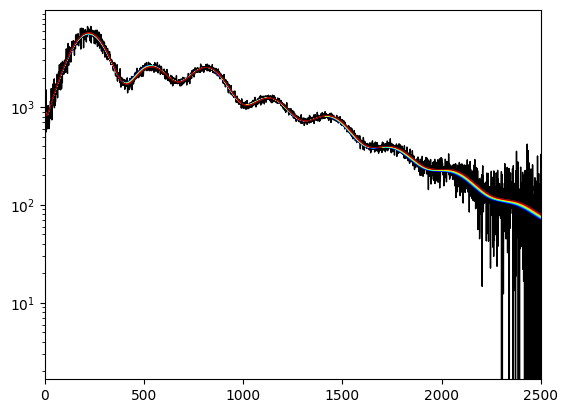

The Best Fitted input Value is 0.022079999999999916 having the chi^2 value is 208
2.066080093383789
Total simulations of 300 Executed in : 2s 6 ms


In [8]:
start_time = time.time() #time calculation

pred_arr = [] #array of prediction [[],[],[]......]
chi2_arr = [] #array of chi2 values[,,,,,...]
input_range = np.arange(0.02,0.023,0.00001) #range

for val in input_range:    
    #params for cosmopower
    params = {'omega_b': [val],#0.02237],
              'omega_cdm': [0.1213],#1200],#0.47],#0.1200],
              'h': [66.943/100],#67.36,
              'tau_reio': [0.056101],#0.0544],
              'n_s': [0.9660],#0.83],#0.945],#0.964
              'ln10^{10}A_s': [np.log( 10**10 *(2.1069*1e-9) )],#3.629
              }
    DATA = 'TT' #'TE' or 'EE' or 'TT'
    if DATA == 'TT':
        pred = Cosmo('TT',params)*dl_fac
        chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
        pred_arr.append(pred)
        chi2_arr.append(chi)
        
    elif DATA == 'TE':
        pred = Cosmo('TE',params)*dl_fac_te
        chi = chi2(Dl_TE,Dl_TE_err_up,Dl_TE_err_bot,pred)
        pred_arr.append(pred)
        chi2_arr.append(chi)
        
    elif DATA == 'EE':
        pred = Cosmo('EE',params)*dl_fac_te
        chi = chi2(Dl_EE,Dl_EE_err_up,Dl_EE_err_bot,pred)
        pred_arr.append(pred)
        chi2_arr.append(chi)
        
    else:
        print('Check DATA Input')



#plotting all the predicted curves
plt.clf()
color_arr = []
for d in np.linspace(0,255,len(input_range)):
    colr = plt.cm.jet(int(d))
    color_arr.append(colr)
if DATA == 'TT':
    plt.subplot(111,yscale='log')
    plt.xlim(0,2500)
    plt.plot(el,Dl_TT, color= 'black', lw =1)
    for ii in range(len(input_range)):
        plt.plot(el,pred_arr[ii], color =  color_arr[ii], lw=0.2)
elif DATA == 'TE':
    plt.subplot(111)
    plt.xlim(0,1995)
    plt.plot(el_te,Dl_TE, color= 'black', lw =1)
    for ii in range(len(input_range)):
        plt.plot(el_te,pred_arr[ii], color =  color_arr[ii], lw=0.2)
elif DATA == 'EE':
    plt.subplot(111)
    plt.xlim(0,1995)
    plt.plot(el_te,Dl_EE, color= 'black', lw =1)
    for ii in range(len(input_range)):
        plt.plot(el_te,pred_arr[ii], color =  color_arr[ii], lw=0.2)
else :
    print('Check DATA Input')


plt.show()

#finding the input value for the  minimum chi2 value
min_chi2 = np.argmin(chi2_arr) #position of minimum chi2
vals = input_range[min_chi2] #finding Input value of minimum chi2
total_values = np.shape(input_range)[0]# Number of values

print('The Best Fitted input Value is', vals,'having the chi^2 value is',min_chi2 )
end_time = time.time() #time calculation
print(end_time - start_time)
tim = time_hr(end_time - start_time) # finding time for excution
print( 'Total simulations of',total_values,'Executed in :',tim)

TT params..
'omega_b':0.02210,
'omega_cdm':0.1205 ,
'h':67.29,
'tau_reio':0.0542,
'n_s':0.966,
'ln10^{10}A_s': [np.log( 10**10 *( 2.0969 ) )],

Recorded Vals
Parameters-------TT--------TE---------EE
Omega_b-------0.022271--0.02225----0.02222
Omega_cdm-----0.1211----0.1215-----0.1213
H-------------67.282----67.317-----66.943
Tau_Reio------0.05355---0.05593----0.56101
N_S-----------0.9667----0.960------0.9660
A_s-----------2.0961----2.909------2.1049

In [14]:
#print(Cosmo_Power('EE',0.0221,0.1205,67.29,0.0542,0.945,2.0969)[1])
omb = np.arange(0.021,0.023,0.0001)
omc = np.arange(0.11,0.13,0.001)
h = np.arange(67,68,0.1)
tau = np.arange(0.05,0.06,0.001)
ns = np.arange(0.9,1,0.01)
As = np.arange(2,2.1,0.001)
rangee = [omb,omc,h,tau,ns,As]
paras = [0.0221,0.1205,67.29,0.0542,0.945,2.0969]
start_time = time.time() #time calculation
p_TT = loop_it('TT',rangee,paras,1) # direct calculations

for x in range(6):
    print(p_TT[0][x],'+-',p_TT[1][x])# looping for print
    
end_time = time.time() #time calculation
tim = time_hr(end_time - start_time) # finding time for excution
print( 'Executed in :',tim)

0.022199999999999994 +- 0.00015491933384829574
0.12000000000000002 +- 1.3877787807814457e-17
67.43999999999997 +- 0.1854723699099035
0.0502 +- 0.00040000000000000034
0.966 +- 0.004898979485566361
2.0773999999999915 +- 0.0038262252939413764
Executed in : 4s 31 ms


In [ ]:
#single parameter method
#print(Cosmo_Power('EE',0.0221,0.1205,67.29,0.0542,0.945,2.0969)[1])
omb = np.arange(0.021,0.023,0.00001)
omc = np.arange(0.11,0.13,0.0001)
h = np.arange(66.5,68,0.01)
tau = np.arange(0.05,0.06,0.00001)
ns = np.arange(0.9,9.5,0.0001)
As = np.arange(2,2.2,0.0001)
rangee = [omb,omc,h,tau,ns,As]
paras = [0.0221,0.1205,67.29,0.0542,0.945,2.0969]
start_time = time.time() #time calculation

sg_t = multiprocessing.Process(target=loop_it('TT',rangee,paras,1), args=(10, ))
#sg_te = multiprocessing.Process(target=loop_it('TE',rangee,paras,10), args=(10, ))
#sg_e = multiprocessing.Process(target=loop_it('EE',rangee,paras,10), args=(10, ))
sg_t.start()
#sg_te.start()
#sg_e.start()
sg_t.join()
#sg_te.join()
#sg_e.join()

end_time = time.time() #time calculation
tim = time_hr(end_time - start_time) # finding time for excution
print( 'Executed in :',tim)

In [40]:
def cospors(rang_arr,par,par_arr = None,thread = False):
    pars = ["omb","omc","h","tau","ns","as"]
    pars_arr = []
    #array generation with parameters names it also as rules that [a,a] does not exist,[a,b] or [a,b] pairs repeat once
    if par_arr == None:
        for xi in pars:
            for yi in pars:
                if xi == yi:
                    pass
                else:
                    pars_arr.append([xi,yi])

        for xi in pars:
            for yi in pars:
                for ys in pars_arr:
                    if [xi,yi]==ys:
                        pars_arr.remove([yi,xi])
                    else:
                        pass
    else:
        pars_arr = par_arr
        
    threads = [] #multithreading for fast calculations
    par_a = [] #this is the results parameters stored

    for i in range(len(pars_arr)): # number of calculations
        if thread == False: #Direct calculations without threading
            par_a.append(cospor('TT',i,pars_arr,rang_arr,par)) #value stored as[[parameters],name of par1,2]
        else:
            t = threading.Thread(target=lambda i=i: par_a.append(cospor("TT",i,pars_arr,rang_arr,par))) #multithreading parameters
            threads.append(t) #saving the threads
            t.start() #start threads  
            
        for t in threads: # for join threads at closing
            t.join() # on joining no threads is in order
    return par_a #[[parameters],name of parameter1 and parameter2] in a list

def de_par(par_aa,prints=False): #for finding average and standard deviation of given parameters
    pars = ["omb","omc","h","tau","ns","as"]
    par = [[],[],[],[],[],[]]
    for i in par_aa:
        par[pars.index(i[1])].append(i[0][pars.index(i[1])])
        par[pars.index(i[2])].append(i[0][pars.index(i[2])])
    pam = [[],[],[],[],[],[]]
    rev =[]
    for i in range(len(pars)):
        pam[i].append([pars[i],[np.average(par[i])],[np.std(par[i])]])
    
    for i in pam:
        if prints == True:
            print(i[0][0],':',np.round(i[0][1],5),'+-',np.round(i[0][2],10))
        else:
            rev.append([i[0][0],':',np.round(i[0][1],5),'+-',np.round(i[0][2],10)])    
    return rev #list(parameters:value +- standard deviation)


In [10]:
#single parameter method
#print(Cosmo_Power('EE',0.0221,0.1205,67.29,0.0542,0.945,2.0969)[1])
omb = np.arange(0.0219,0.0224,0.00001)
omc = np.arange(0.119,0.122,0.0001)
h = np.arange(66.5,68.3,0.01)
tau = np.arange(0.05,0.06,0.0001)
ns = np.arange(0.93,0.98,0.0001)
As = np.arange(2.07,2.15,0.0001)
rangee = [omb,omc,h,tau,ns,As]
paras = [0.0221,0.1205,67.29,0.0542,0.945,2.0969]
st = time.time()
ar1 = [['omb', 'omc'], ['omb', 'h'], ['omb', 'tau'], ['omb', 'ns'],['omb', 'as']]
ar2 = [['omc', 'h'], ['omc', 'tau'], ['omc', 'ns'], ['omc', 'as']]
ar3 = [['h', 'tau'], ['h', 'ns'], ['h', 'as']]
ar4 = [['tau', 'ns'], ['tau', 'as'], ['ns', 'as']]
par_ar1 = cospors(rangee,paras,ar1,True)
print('completed :',par_ar1)
par_ar2 = cospors(rangee,paras,ar2,True)
print('completed :',par_ar2)
par_ar3 = cospors(rangee,paras,ar3,True)
print('completed :',par_ar3)
par_ar4 = cospors(rangee,paras,ar4,True)
print('completed :',par_ar4)
et = time.time()
print('Time Taken : ',time_hr(et-st))

completed : [[[0.02236999999999998, 0.11970000000000001, 67.29, 0.0542, 0.945, 2.0969], 'omb', 'omc'], [[0.022219999999999986, 0.1205, 66.74000000000012, 0.0542, 0.945, 2.0969], 'omb', 'h'], [[0.02236999999999998, 0.1205, 67.29, 0.05, 0.945, 2.0969], 'omb', 'tau'], [[0.02209999999999999, 0.1205, 67.29, 0.0542, 0.9675999999999959, 2.0969], 'omb', 'ns'], [[0.02235999999999998, 0.1205, 67.29, 0.0542, 0.945, 2.1159000000000967], 'omb', 'as']]
completed : [[[0.0221, 0.12070000000000004, 66.53000000000002, 0.0542, 0.945, 2.0969], 'omc', 'h'], [[0.0221, 0.12050000000000004, 67.29, 0.05, 0.945, 2.0969], 'omc', 'tau'], [[0.0221, 0.12090000000000005, 67.29, 0.0542, 0.9688999999999958, 2.0969], 'omc', 'ns'], [[0.0221, 0.12100000000000005, 67.29, 0.0542, 0.945, 2.1216000000001087], 'omc', 'as']]
completed : [[[0.0221, 0.1205, 67.02000000000027, 0.05, 0.945, 2.0969], 'h', 'tau'], [[0.0221, 0.1205, 67.45000000000049, 0.0542, 0.9687999999999958, 2.0969], 'h', 'ns'], [[0.0221, 0.1205, 67.0400000000002

In [48]:
arrw = [[[0.02236999999999998, 0.11970000000000001, 67.29, 0.0542, 0.945, 2.0969], 'omb', 'omc'], [[0.022219999999999986, 0.1205, 66.74000000000012, 0.0542, 0.945, 2.0969], 'omb', 'h'], [[0.02236999999999998, 0.1205, 67.29, 0.05, 0.945, 2.0969], 'omb', 'tau'], [[0.02209999999999999, 0.1205, 67.29, 0.0542, 0.9675999999999959, 2.0969], 'omb', 'ns'], [[0.02235999999999998, 0.1205, 67.29, 0.0542, 0.945, 2.1159000000000967], 'omb', 'as']
       ,[[0.0221, 0.12070000000000004, 66.53000000000002, 0.0542, 0.945, 2.0969], 'omc', 'h'], [[0.0221, 0.12050000000000004, 67.29, 0.05, 0.945, 2.0969], 'omc', 'tau'], [[0.0221, 0.12090000000000005, 67.29, 0.0542, 0.9688999999999958, 2.0969], 'omc', 'ns'], [[0.0221, 0.12100000000000005, 67.29, 0.0542, 0.945, 2.1216000000001087], 'omc', 'as']
       ,[[0.0221, 0.1205, 67.02000000000027, 0.05, 0.945, 2.0969], 'h', 'tau'], [[0.0221, 0.1205, 67.45000000000049, 0.0542, 0.9687999999999958, 2.0969], 'h', 'ns'], [[0.0221, 0.1205, 67.04000000000028, 0.0542, 0.945, 2.1153000000000954], 'h', 'as']
       ,[[0.0221, 0.1205, 67.29, 0.05490000000000014, 0.9689999999999958, 2.0969], 'tau', 'ns'], [[0.0221, 0.1205, 67.29, 0.05, 0.945, 2.100400000000064], 'tau', 'as'], [[0.0221, 0.1205, 67.29, 0.0542, 0.9690999999999957, 2.09380000000005], 'ns', 'as']]
#arrw.append(par_ar1)

#print(arrw)
xe = de_par(arrw,True)
#Parameters found ufing two parameters attachments

omb : [0.02228] +- [0.00010818]
omc : [0.12056] +- [0.00046303]
h : [66.956] +- [0.31090835]
tau : [0.05098] +- [0.00196]
ns : [0.96868] +- [0.00054918]
as : [2.1094] +- [0.01049057]


In [ ]:
#end of 2 1 and 2 parameters

In [49]:
pars = ["omb","omc","h","tau","ns","as"]
par = [[],[],[],[],[],[]]
for i in arrw:
    par[pars.index(i[1])].append(i[0][pars.index(i[1])])
    par[pars.index(i[2])].append(i[0][pars.index(i[2])])
    #print(i[1],":",i[0][pars.index(i[1])],i[2],":",i[0][pars.index(i[2])])
pam = [[],[],[],[],[],[]]
for i in range(len(pars)):
    pam[i].append([pars[i],[np.average(par[i])],[np.std(par[i])]])
for i in pam:
    print(i[0][0],':',np.round(i[0][1],5),'+-',np.round(i[0][2],10))

omb : [0.02228] +- [0.00010818]
omc : [0.12056] +- [0.00046303]
h : [66.956] +- [0.31090835]
tau : [0.05098] +- [0.00196]
ns : [0.96868] +- [0.00054918]
as : [2.1094] +- [0.01049057]


In [52]:
for i in arrw:
    print(i[1],':',np.round(i[0][pars.index(i[1])],5),'&',i[2],':',np.round(i[0][pars.index(i[2])],5))

omb : 0.02237 & omc : 0.1197
omb : 0.02222 & h : 66.74
omb : 0.02237 & tau : 0.05
omb : 0.0221 & ns : 0.9676
omb : 0.02236 & as : 2.1159
omc : 0.1207 & h : 66.53
omc : 0.1205 & tau : 0.05
omc : 0.1209 & ns : 0.9689
omc : 0.121 & as : 2.1216
h : 67.02 & tau : 0.05
h : 67.45 & ns : 0.9688
h : 67.04 & as : 2.1153
tau : 0.0549 & ns : 0.969
tau : 0.05 & as : 2.1004
ns : 0.9691 & as : 2.0938
